In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class helper():
    def _weighted_sum(img, filter):
        weighted_sum = (img*filter).sum()
        return int(weighted_sum+0.5)

    
    def convolute(img, filter):

        if len(img.shape) == len(filter.shape):
            try:
                assert img.shape[2] == filter.shape[2], "# channels of image and filter must be the same"
            except IndexError:
                img = img[:, :, np.newaxis]
                filter = filter[:, :, np.newaxis]
        else:
            raise ValueError("# channels of image and filter must be the same")

        pw = filter.shape[0]//2

        pad_width = ((pw, pw), (pw, pw), (0, 0))
        padded_img = np.pad(img, pad_width)

        new_img = np.zeros(img.shape)
        h, w = padded_img.shape[:2]
        for i in range(pw, h-pw):
            for j in range(pw, w-pw):
                slice = padded_img[i-pw:i+pw+1, j-pw:j+pw+1]
                weighted_sum = helper._weighted_sum(slice, filter)
                new_img[i-pw, j-pw] = weighted_sum
        
        new_img = np.round(np.clip(new_img, 0, 255)).astype(np.uint8).squeeze()
        return new_img

class GaussianFilter():
    def __init__(self, src, ksize, sigma):

        if 0 in ksize:
            size = 2 * int(4 * sigma + 0.5) + 1
            self.ksize = (size, size)
        else:
            self.ksize = ksize

        self.src = src
        self.sigma = sigma

    def __call__(self):
        self.filter = self.gaussian_filter(self.ksize, self.sigma)
        img_covolved = self.apply_filter_over_channels(self.src, self.filter)
        return img_covolved

    def gaussian_function(self, sigma, x, y):
        t1 = 1/(2*np.pi*(sigma**2))
        t2 = np.exp(-(x**2+y**2)/(2* sigma**2))
        G = t1*t2
        return G

    def gaussian_filter(self, shape, sigma):
        m, n = shape
        m_h, n_h = m//2, n//2

        filter = np.zeros(shape)
        for i in range(-m_h, m_h+1):
            for j in range(-n_h, n_h+1):
                filter[i+m_h, j+n_h] = self.gaussian_function(sigma, i, j)
        filter /= filter.sum() 
        return filter
    
    def apply_filter_over_channels(self, img, filter):
        img_covolved = np.zeros_like(img)
        for i, channel in enumerate(img.transpose(2, 0, 1)):
            img_covolved[:, :, i] = helper.convolute(channel, filter)
            
        return img_covolved

class SobelFilter():
    def __init__(self, src, dx, dy, ksize=(3, 3)):
        if len(src.shape) == 3:
            src = np.squeeze(src)
        kx = np.array([[-1, 0, 1],
                       [-2, 0, 2],
                       [-1, 0, 1]])
        ky = kx.T
        
        kxy = kx * ky

        if dx == 1 and dy==0: k=kx
        elif dx == 0 and dy==1: k=ky
        elif dx == 1 and dy==1: k=kxy
        else: raise Exception('(dx, dy) must be (0, 1), (1, 0) or (1, 1) till now')

        self.src = src
        self.k = k

    def __call__(self):
        sobel_img = helper.convolute(self.src, self.k)
        return sobel_img

class CannyFilter:
    def mynon_max_suppression(self, G, theta):
        m, n = theta.shape
        theta[theta<0] += np.pi
        theta[theta>np.pi] -= np.pi
        threshold = 1-np.cos((67.5/180)*np.pi)
        img_suppressed = np.zeros_like(G)

        # G = np.pad(G, 1)

        for i in range(1, m-1):
            for j in range(1, n-1):
                th = theta[i, j]

                # calculates the cartesian coordinates from theta
                x = np.cos(th)
                y = np.sin(th)

                # step is just 0 or 1
                sx = int(x + threshold* ((-1)**(x<0))) # step in the direction of x
                sy = int(y + threshold) # step in the direction of y

                q = G[i+sy, j-sx]
                r = G[i-sy, j+sx]


                g = G[i, j]

                if g == max(q, r, g):
                    img_suppressed[i, j] = g
        return img_suppressed

    def mythreshold(self, img_suppressed, low=0.1, high=0.5):    
        res = np.zeros_like(img_suppressed)
        
        high = high*img_suppressed.max()
        low = low*img_suppressed.max()
        
        high_value = 255
        weak_value = 125

        res[img_suppressed>=high] = high_value
        res[(img_suppressed>=low) & (img_suppressed<high)] = weak_value

        return res, weak_value, high_value

    def myHysteresis(self, img, weak_value, high_value):
        m, n = img.shape
        pw = 1

        filter = np.ones((3, 3))*high_value
        filter[1, 1] = 0

        for i in range(1, m-1):
            for j in range(1, n-1):
                if img[i, j] == weak_value:
                    slice = img[i-pw:i+pw+1, j-pw:j+pw+1]
                    istrong = np.any(slice == filter)
                    img[i-pw, j-pw] = istrong*high_value

        return img


    def detect(self, img, threshold1, threshold2):
        b, g, r = img.transpose(2, 0, 1)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = (0.299*r + 0.587*g + 0.114*b).reshape(*img.shape[:2], 1)

        img = GaussianFilter(img, ksize=(0, 0), sigma=1)()
        mysobel_img_x = SobelFilter(img, 1, 0)()
        mysobel_img_y = SobelFilter(img, 0, 1)()

        G = np.hypot(mysobel_img_x, mysobel_img_y)
        G = (G / G.max() *255).astype(np.uint8)

        theta = np.arctan2(mysobel_img_y, mysobel_img_x)

        img_suppressed = self.mynon_max_suppression(G, theta)
        img_threshold, high_value, weak_value = self.mythreshold(img_suppressed, threshold1, threshold2)
        img_hysteresis = self.myHysteresis(img_threshold, high_value, weak_value)
        return img_hysteresis


# Test Image

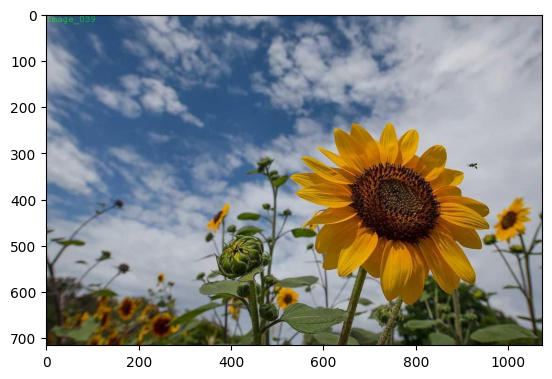

In [3]:
img = cv2.imread("flower.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

# GaussianFilter

In [4]:
# np.random.seed(42)
# img = (np.random.random((10, 5, 3))*256).astype(np.uint8)
img = cv2.imread("flower.jpeg")
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

sig = 5
ksize = (0, 0)

myGaussian_img = GaussianFilter(img, ksize, sig)()
openGaussian_img = cv2.GaussianBlur(img, ksize, sig, borderType=cv2.BORDER_CONSTANT)

print(f"percentage of pexels with mistakes: {(myGaussian_img != openGaussian_img).sum() / myGaussian_img.size:0.3}\n")
print("portion of img_myGaussian:\n", myGaussian_img[0:5, 0,])
print("portion of img_opencv:\n", openGaussian_img[0:5, 0,])

percentage of pexels with mistakes: 0.0737

portion of img_myGaussian:
 [[42 41 30]
 [48 48 34]
 [53 53 38]
 [58 59 41]
 [62 63 44]]
portion of img_opencv:
 [[42 41 29]
 [47 48 34]
 [53 53 37]
 [58 59 41]
 [62 63 44]]


These mistakes are due to round calculations

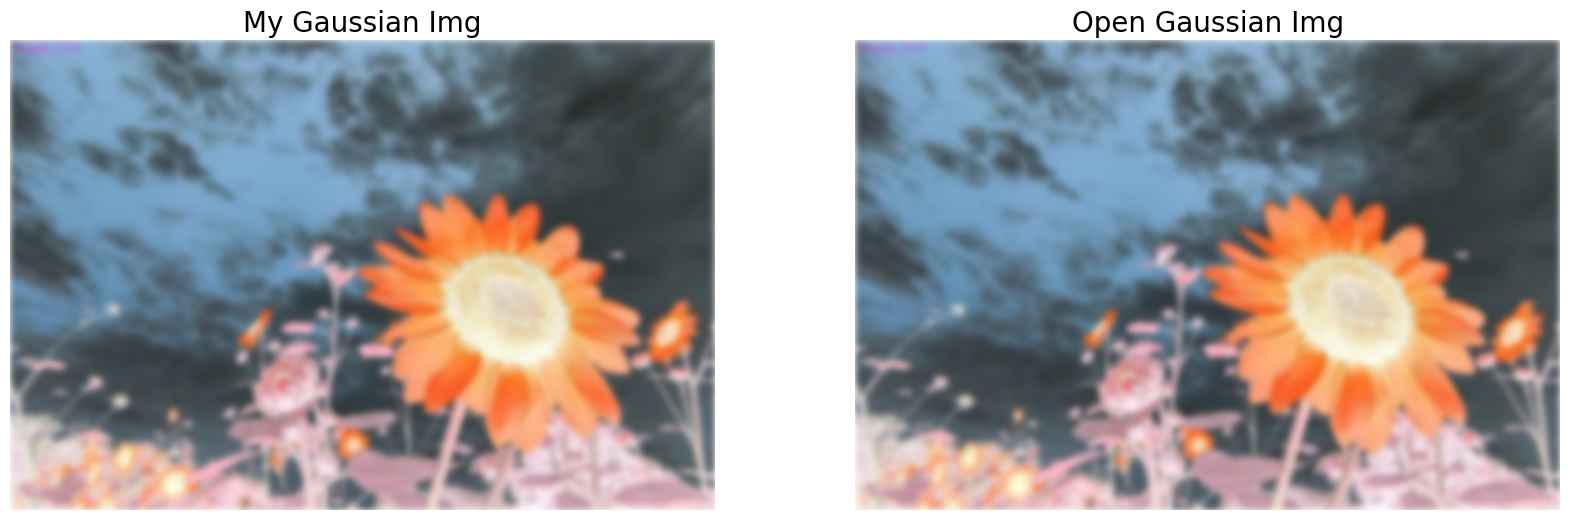

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 7)
ax1.axis('off')
ax2.axis('off')

ax1.set_title("My Gaussian Img", size=20)
ax2.set_title("Open Gaussian Img", size=20)

ax1.imshow(~myGaussian_img, cmap="Greys")
ax2.imshow(~openGaussian_img, cmap="Greys")

plt.show()

# SobelFilter

In [6]:
img = cv2.imread("flower.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

mysobel_img_x = SobelFilter(img, 1, 0)()
mysobel_img_y = SobelFilter(img, 0, 1)()
mysobel_img = SobelFilter(img, 1, 1)()

opensobel_img_x = cv2.Sobel(img, -1, 1, 0, ksize=3, borderType=cv2.BORDER_CONSTANT)
opensobel_img_y = cv2.Sobel(img, -1, 0, 1, ksize=3, borderType=cv2.BORDER_CONSTANT)
opensobel_img = cv2.Sobel(img, -1, 1, 1, ksize=3, borderType=cv2.BORDER_CONSTANT)

print(np.all(mysobel_img_x == opensobel_img_x))
print(np.all(mysobel_img_y == opensobel_img_y))
print(np.all(mysobel_img == opensobel_img))

True
True
True


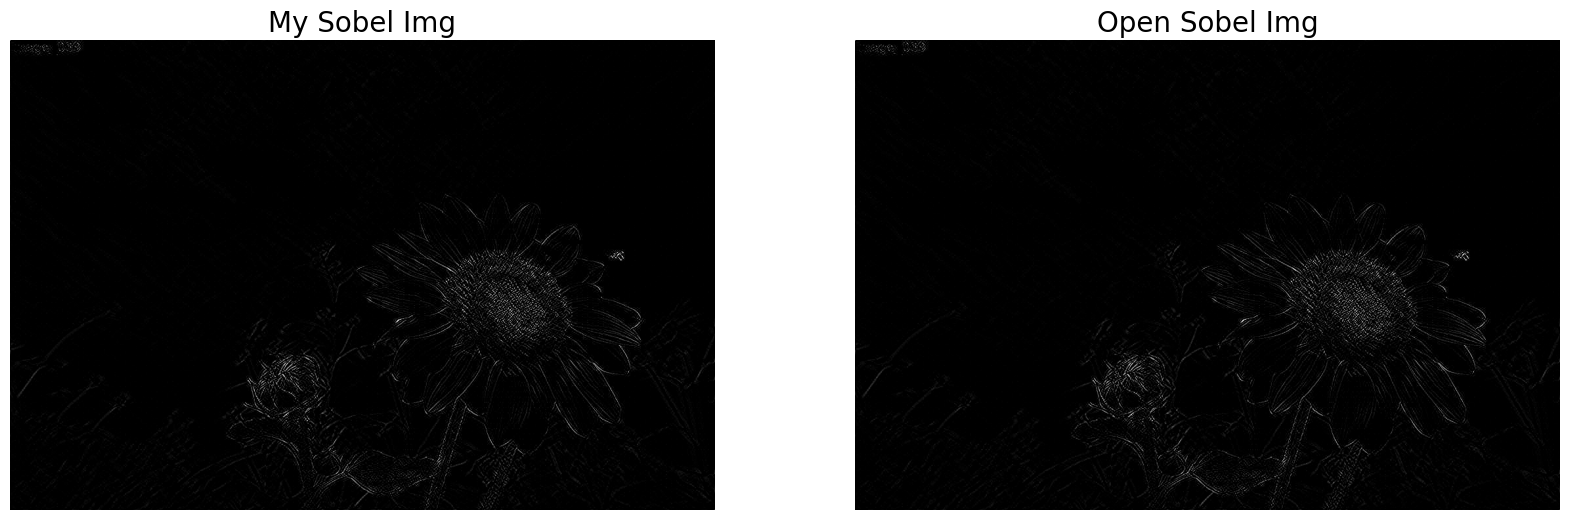

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 7)
ax1.axis('off')
ax2.axis('off')

ax1.set_title("My Sobel Img", size=20)
ax2.set_title("Open Sobel Img", size=20)

ax1.imshow(~mysobel_img, cmap="Greys")
ax2.imshow(~opensobel_img, cmap="Greys")

plt.show()

# CannyFilter:

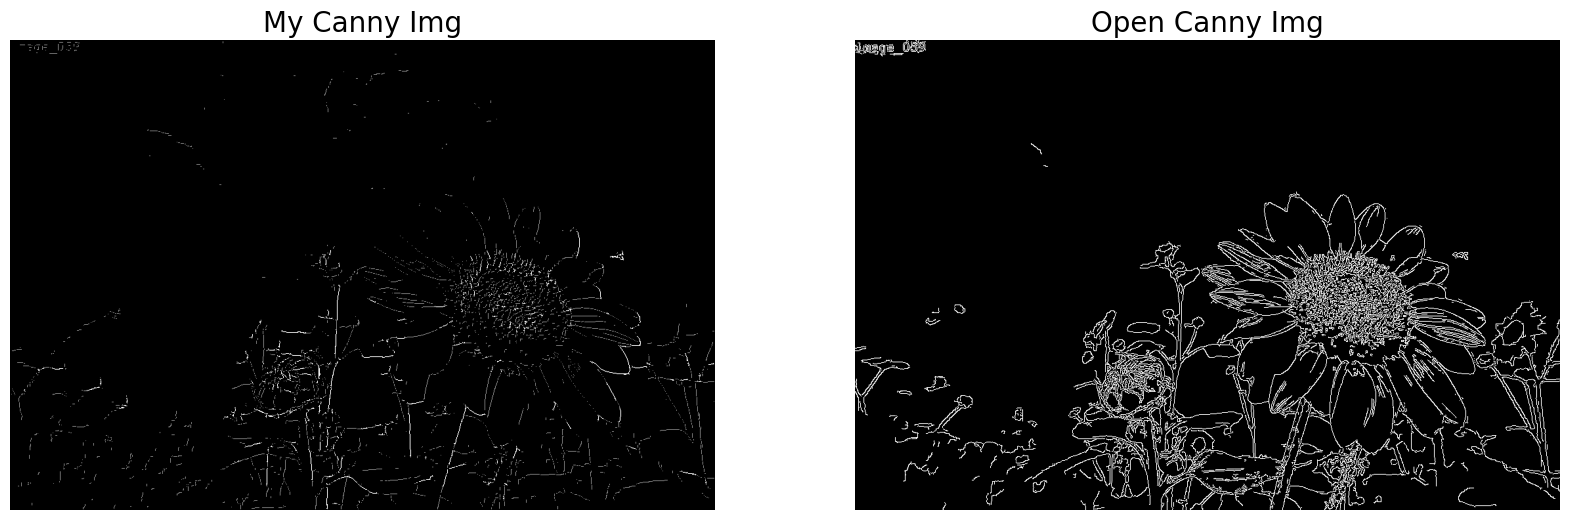

In [8]:
img = cv2.imread("flower.jpeg")

mycanny_img = CannyFilter().detect(img, 0.2, 0.5)
opencanny_img = cv2.Canny(img, 100, 200)


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 7)
ax1.axis('off')
ax2.axis('off')

ax1.set_title("My Canny Img", size=20)
ax2.set_title("Open Canny Img", size=20)

ax1.imshow(~mycanny_img, cmap="Greys")
ax2.imshow(~opencanny_img, cmap="Greys")

plt.show()